In this notebook, I am classifying NHL forwards and defensemen into different archetypes, using models in the SciKitLearn library. Instead of querying from my database here, I opted for csv file as there is less data and it is largely unnecessary to use the database here.

Data Preparation (Imports)

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

Load the 2021-2022 and 2022-2023 seasons and combine them, and load 2023-2024 season.

In [119]:
# Load 2021-2022 and 2022-2023 skater season CSV files (your paths here)
df_2021_2022 = pd.read_csv('/mnt/c/Users/killi/Documents/Fantasy-Hockey-App/backend/database/csv_data/skaters_2021-22.csv')
df_2022_2023 = pd.read_csv('/mnt/c/Users/killi/Documents/Fantasy-Hockey-App/backend/database/csv_data/skaters_2022-23.csv')

# Concatenate the DataFrames
df_training = pd.concat([df_2021_2022, df_2022_2023])

# Save the combined DataFrame to a new CSV file
df_training.to_csv('training_data.csv', index=False)


Preprocessing (Transform time metrics to decimal, clean by removing players with under 24 games played and under and removing unnecessary stats) for training and testing set.

In [120]:
# Keep only necessary stats for training model
columns_to_keep = ['Name', 'Pos', 'GP', 'G', 'A', 'P', 'PIM', 'TOI', 'SH', 'G/GP', 'A/GP', 'P/GP', 'HITS', 'BS']
df_training = df_training[columns_to_keep]

# Remove players with under 25 games played
df_training = df_training[df_training['GP'] >= 25]

# Convert ice time to decimal and fix erroneous values
def time_to_decimal(time):
    if pd.isna(time):
        return 0
    
    time = str(time)

    try:
        # Remove extra :00 for ice time stats (erroneous values)
        if time.count(':') == 2:
            time = ':'.join(time.split(':')[:2])
        
        # Convert ice time to decimal
        minutes, seconds = map(int, time.split(':'))
        return minutes + seconds / 100
    
    except ValueError:
        return 0

df_training['TOI'] = df_training['TOI'].apply(time_to_decimal)
df_training['SH'] = df_training['SH'].apply(time_to_decimal)

df_training.to_csv('training_data.csv', index=False)

Create base labels for forwards and defensemen and save it to new CSV. Here, I use arbitrary metrics I self defined based on my general knowledge, but these are imperfect (hence why we use machine learning!)

In [121]:
# TODO: Dynamic Labeling - relative performance within a season, so not era dependent

# Calculate the goal/assist ratio and handle cases where assists are 0 to avoid division by zero
df_training['G/A'] = df_training['G'] / df_training['A'].replace(0, np.nan)

# Replace NaN values (resulting from division by zero) with a very high value or a specific value like 0
df_training['G/A'] = df_training['G/A'].fillna(0)

# Label forward and defense archetypes
def label_player(row):
    # Check if the player is a forward
    if row['Pos'] == 'F':
        # Power-forward
        if row['P/GP'] >= 0.5 and ((row['HITS'] >= 90 and row['PIM'] >= 60) or row['HITS'] >= 150):
            return 'Power-forward'
        # Two-way
        elif row['P/GP'] >= 0.45 and row['SH'] > 1.30:
            return 'Two-way'
        # Sniper
        elif row['P/GP'] >= 0.45 and row['G/GP'] >= 0.35 and (row['G/A'] >= 0.8):
            return 'Sniper'
        # Playmaker
        elif row['P/GP'] >= 0.45:
            return 'Playmaker'
        # Grinder
        else:
            return 'Grinder'
    elif row['Pos'] == 'D':
        # All-around
        if row['P/GP'] >= 0.4 and row['TOI'] >= 21.00 and row['SH'] >= 1.30:
            return 'All-around'
        # Offensive
        elif row['P/GP'] >= 0.35:
            return 'Offensive'
        else:
            return 'Defensive'
    else:
        return 'N/A'

# Apply the function to create a new 'Label' column
df_training['Label'] = df_training.apply(label_player, axis=1)

# Save the updated DataFrame to a new CSV file
df_training.to_csv('training_data.csv', index=False)


Define features and targets, and one-hot encode position. Split data into training and test set (80% training and 20% test)

In [122]:
x = df_training.drop(columns=['Name', 'Label'])
y = df_training['Label']

categorical_features = ['Pos']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough'
)

x_processed = preprocessor.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_processed, y, test_size=0.2, random_state=42)

Models here and training (random forest, SVM, decision trees, KNN), use K fold cross validation

In [123]:
# Define different models
models = {
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier()
}

# Set up K-Fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define metrics in which to gauge model performance
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1': make_scorer(f1_score, average='weighted', zero_division=0)
}
for name, model in models.items():
    scores = cross_validate(model, x_train, y_train, cv=kf, scoring=scoring, return_train_score=False)

    print(f"{name} - Test Accuracy: {scores['test_accuracy'].mean():.4f}")
    print(f"{name} - Test Precision: {scores['test_precision'].mean():.4f}")
    print(f"{name} - Test Recall: {scores['test_recall'].mean():.4f}")
    print(f"{name} - Test F1 Score: {scores['test_f1'].mean():.4f}")

Random Forest - Test Accuracy: 0.9726
Random Forest - Test Precision: 0.9717
Random Forest - Test Recall: 0.9726
Random Forest - Test F1 Score: 0.9690
Support Vector Machine - Test Accuracy: 0.7215
Support Vector Machine - Test Precision: 0.6659
Support Vector Machine - Test Recall: 0.7215
Support Vector Machine - Test F1 Score: 0.6680
Decision Tree - Test Accuracy: 0.9836
Decision Tree - Test Precision: 0.9857
Decision Tree - Test Recall: 0.9836
Decision Tree - Test F1 Score: 0.9834
KNN - Test Accuracy: 0.7041
KNN - Test Precision: 0.6856
KNN - Test Recall: 0.7041
KNN - Test F1 Score: 0.6772


Confusion matrix breakdown:

Confusion Matrix for Random Forest:


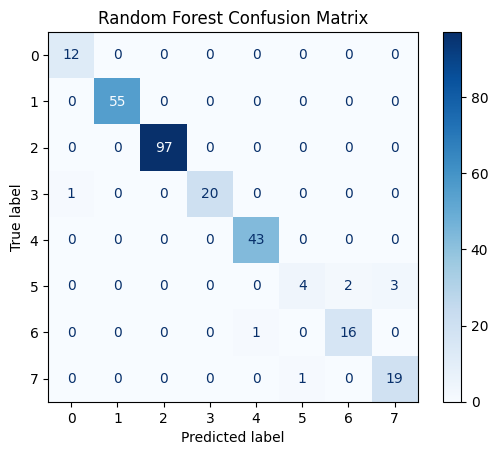

Confusion Matrix for Support Vector Machine:


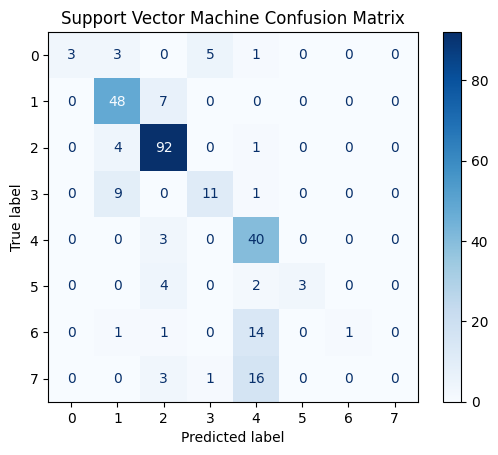

Confusion Matrix for Decision Tree:


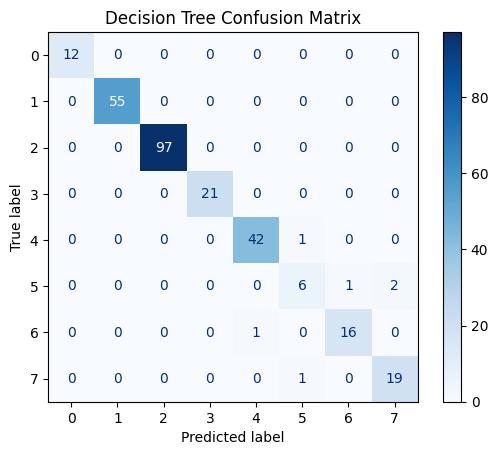

Confusion Matrix for KNN:


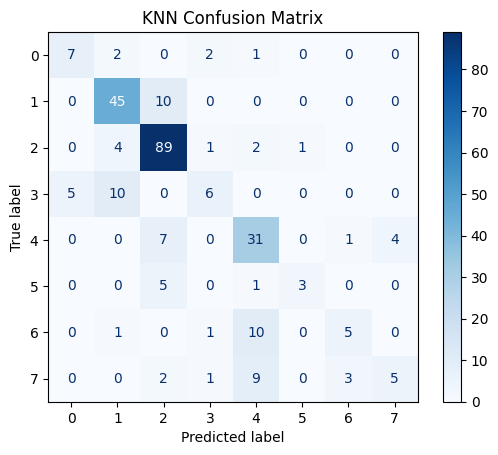

In [128]:
# Map labels to value
# label_mapping = {
#     0: 'Power-forward',
#     1: 'Two-way',
#     2: 'Sniper',
#     3: 'Playmaker',
#     4: 'Grinder',
#     5: 'All-around',
#     6: 'Offensive',
#     7: 'Defensive'
# }

def plot_confusion_matrix(y_true, y_pred, labels, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Get the unique labels from the training set
labels = sorted(y.unique())

for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    print(f"Confusion Matrix for {name}:")
    plot_confusion_matrix(y_test, y_pred, labels=labels, title=f'{name} Confusion Matrix')


In [125]:
# def plot_feature_importance(model, feature_names, title='Feature Importance'):
#     if hasattr(model, 'feature_importances_'):
#         importances = model.feature_importances_
#         indices = importances.argsort()[::-1]
        
#         plt.figure()
#         plt.title(title)
#         plt.bar(range(len(feature_names)), importances[indices], align='center')
#         plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=90)
#         plt.xlim([-1, len(feature_names)])
#         plt.show()
#     else:
#         print(f"Model {model} does not have feature importances.")

# for name, model in models.items():
#     if name in ['Random Forest', 'Decision Tree']:
#         model.fit(x_train, y_train)
#         print(f"Feature Importance for {name}:")
#         plot_feature_importance(model, x_train.columns, title=f'{name} Feature Importance')


Feature Importance for Random Forest:


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

Hyperparameter  (save evaluation scores of each model of different hyperparameters)

Model Deployment/Picking best model

Adding labels derived from test set to my SQL database

Use finished model to classify players from 2023-2024